In [13]:
import face_recognition
import cv2
import pickle
import numpy as np
from ultralytics import YOLO
from datetime import datetime

# Load known student face encodings
with open('student_encodings.pkl', 'rb') as f:
    student_encodings = pickle.load(f)

known_rolls = list(student_encodings.keys())
known_embeddings = list(student_encodings.values())

# Load YOLOv8 face detection model
model = YOLO("face_yolov8m.pt")

# Load group image
group_img_path = 'group.jpeg'
image = cv2.imread(group_img_path)
original_image = image.copy()
results = model(image)[0]

# Face matching threshold
MATCH_THRESHOLD = 6.0

# Attendance containers
present = []
unknown_count = 0

for box in results.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    width, height = x2 - x1, y2 - y1

    if width < 40 or height < 40:
        continue

    face_crop = image[y1:y2, x1:x2]

    try:
        face_crop = cv2.resize(face_crop, (150, 150))
        rgb_face = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
        encodings = face_recognition.face_encodings(rgb_face)
    except:
        continue

    label = "Unknown"

    if encodings:
        embedding = encodings[0]
        distances = face_recognition.face_distance(known_embeddings, embedding)

        if len(distances) > 0:
            min_distance = np.min(distances)
            min_index = np.argmin(distances)

            if min_distance < MATCH_THRESHOLD:
                roll = known_rolls[min_index]
                present.append(roll)
                label = roll
            else:
                unknown_count += 1
        else:
            unknown_count += 1
    else:
        unknown_count += 1

    color = (0, 255, 0) if label != "Unknown" else (0, 0, 255)
    cv2.rectangle(original_image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(original_image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

present = sorted(set(present))
absent = sorted(set(known_rolls) - set(present))

# Save annotated image
output_img_path = "attendance_output.jpg"
cv2.imwrite(output_img_path, original_image)

# Save attendance report
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
report_path = f"attendance_report_{now}.txt"

with open(report_path, "w", encoding="utf-8") as f:
    f.write("Attendance Report\n")
    f.write(f"Present ({len(present)}): {present}\n")
    f.write(f"Absent ({len(absent)}): {absent}\n")
    f.write(f"Unknown Persons Detected: {unknown_count}\n")

# Print summary
print("Attendance Report")
print(f"Present ({len(present)}): {present}")
print(f"Absent ({len(absent)}): {absent}")
print(f"Unknown Persons Detected: {unknown_count}")
print(f"Annotated image saved as '{output_img_path}'")
print(f"Report saved as '{report_path}'")



0: 416x640 27 faces, 348.8ms
Speed: 3.1ms preprocess, 348.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)
Attendance Report
Present (23): ['23MIT001', '23MIT002', '23MIT006', '23MIT007', '23MIT008', '23MIT009', '23MIT010', '23MIT015', '23MIT020', '23MIT025', '23MIT026', '23MIT027', '23MIT028', '23MIT033', '23MIT036', '23MIT038', '23MIT046', '23MIT048', '23MIT051', '23MIT053', '23MIT059', '23MIT060', '23MIT066']
Absent (43): ['23MIT003', '23MIT004', '23MIT005', '23MIT011', '23MIT012', '23MIT013', '23MIT014', '23MIT016', '23MIT017', '23MIT018', '23MIT019', '23MIT021', '23MIT022', '23MIT023', '23MIT024', '23MIT029', '23MIT030', '23MIT031', '23MIT032', '23MIT034', '23MIT035', '23MIT037', '23MIT039', '23MIT040', '23MIT041', '23MIT042', '23MIT043', '23MIT044', '23MIT045', '23MIT047', '23MIT049', '23MIT050', '23MIT052', '23MIT054', '23MIT055', '23MIT056', '23MIT057', '23MIT058', '23MIT061', '23MIT062', '23MIT063', '23MIT064', '23MIT065']
Unknown Persons Detected: 2
Annot

In [ ]:
#for saving encodings of an image

import os
import cv2
import pickle
import face_recognition
from datetime import datetime

def get_face_crop_from_txt(image, label_path):
    h, w = image.shape[:2]
    with open(label_path, 'r') as f:
        line = f.readline().strip().split()
        if len(line) == 5:
            _, x_center, y_center, width, height = map(float, line)
            x1 = int((x_center - width / 2) * w)
            y1 = int((y_center - height / 2) * h)
            x2 = int((x_center + width / 2) * w)
            y2 = int((y_center + height / 2) * h)
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)
            return image[y1:y2, x1:x2]
    return None

# Directories and output files
img_dir = "students"
label_dir = "boundings"
output_file = "student_encodings2.pkl"
skipped_output = "skipped_encodings.pkl"
failed_output = "failed_encodings.pkl"
report_file = "encoding_report.txt"
skipped_dir = "logs/skipped"
failed_dir = "logs/failed"

# Create directories if not exist
os.makedirs(skipped_dir, exist_ok=True)
os.makedirs(failed_dir, exist_ok=True)

# Initialize
student_encodings = {}
skipped_encodings = {}
failed_encodings = {}
success, no_face, skipped, error = 0, 0, 0, 0

# Open log file
with open(report_file, 'w') as log:
    log.write(f"Encoding Report - {datetime.now()}\n")
    log.write("="*50 + "\n")

    for filename in os.listdir(img_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            roll = os.path.splitext(filename)[0]
            img_path = os.path.join(img_dir, filename)
            label_path = os.path.join(label_dir, f"{roll}.txt")

            if not os.path.exists(label_path):
                msg = f"[Missing] Label file missing for {roll}"
                print(msg)
                log.write(msg + "\n")
                continue

            image = cv2.imread(img_path)
            face_crop = get_face_crop_from_txt(image, label_path)

            if face_crop is None:
                msg = f"[Warning] Could not extract face for {roll}"
                print(msg)
                log.write(msg + "\n")
                no_face += 1
                cv2.imwrite(os.path.join(failed_dir, f"{roll}.jpg"), image)
                continue

            try:
                face_crop = cv2.resize(face_crop, (150, 150))
                rgb_face = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

                cv2.imshow(f"Encoding Face - {roll}", face_crop)
                key = cv2.waitKey(0)
                if key == ord('s'):
                    msg = f"[Skipped] Skipped encoding for {roll}"
                    print(msg)
                    log.write(msg + "\n")
                    skipped += 1
                    cv2.imwrite(os.path.join(skipped_dir, f"{roll}.jpg"), face_crop)

                    encodings = face_recognition.face_encodings(rgb_face)
                    if encodings:
                        skipped_encodings[roll] = encodings[0]

                    cv2.destroyAllWindows()
                    continue
                cv2.destroyAllWindows()

                encodings = face_recognition.face_encodings(rgb_face)

                if encodings:
                    student_encodings[roll] = encodings[0]
                    msg = f"[Saved] Encoding saved for {roll}"
                    print(msg)
                    log.write(msg + "\n")
                    success += 1
                else:
                    msg = f"[No Encoding] No face encoding found for {roll}"
                    print(msg)
                    log.write(msg + "\n")
                    no_face += 1
                    cv2.imwrite(os.path.join(failed_dir, f"{roll}.jpg"), face_crop)

                    failed_encodings[roll] = None  # Save as None for consistency

            except Exception as e:
                msg = f"[Error] Error processing {roll}: {e}"
                print(msg)
                log.write(msg + "\n")
                error += 1
                cv2.imwrite(os.path.join(failed_dir, f"{roll}.jpg"), image)
                failed_encodings[roll] = None

    # Final report summary
    log.write("\nEncoding Summary:\n")
    log.write(f"Success: {success}\n")
    log.write(f"No face detected: {no_face}\n")
    log.write(f"Skipped manually: {skipped}\n")
    log.write(f"Errors: {error}\n")
    log.write(f"Encodings saved to '{output_file}'\n")

# Save encodings to pickle
with open(output_file, 'wb') as f:
    pickle.dump(student_encodings, f)

with open(skipped_output, 'wb') as f:
    pickle.dump(skipped_encodings, f)

with open(failed_output, 'wb') as f:
    pickle.dump(failed_encodings, f)

# Print summary
print("\nEncoding Summary:")
print(f"Success: {success}")
print(f"No face detected: {no_face}")
print(f"Skipped manually: {skipped}")
print(f"Errors: {error}")
print(f"Encodings saved to '{output_file}'")
print(f"Skipped encodings saved to '{skipped_output}'")
print(f"Failed encodings saved to '{failed_output}'")
print(f"Log saved to '{report_file}'")


In [16]:
import face_recognition
import cv2
import pickle
import numpy as np
from ultralytics import YOLO
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Parameters
MATCH_THRESHOLD = 0.6
ENCODING_FILE = 'student_encodings.pkl'
GROUP_IMAGE_PATH = 'group.jpeg'
YOLO_MODEL = 'face_yolov8m.pt'

# Load known encodings
with open(ENCODING_FILE, 'rb') as f:
    student_encodings = pickle.load(f)

known_rolls = list(student_encodings.keys())
known_embeddings = list(student_encodings.values())

# Load YOLO model
model = YOLO(YOLO_MODEL)

# Load image
image = cv2.imread(GROUP_IMAGE_PATH)
original_image = image.copy()
results = model(image)[0]

# Initialize
present = []
unknown_count = 0
true_labels = []
pred_labels = []

# Face detection and recognition
for box in results.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    face_crop = image[y1:y2, x1:x2]

    try:
        face_crop = cv2.resize(face_crop, (150, 150))
        rgb_face = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
        encodings = face_recognition.face_encodings(rgb_face)

        if encodings:
            embedding = encodings[0]
            distances = face_recognition.face_distance(known_embeddings, embedding)
            min_distance = np.min(distances)
            min_index = np.argmin(distances)

            if min_distance < MATCH_THRESHOLD:
                roll = known_rolls[min_index]
                present.append(roll)
                label = roll
                true_labels.append(1)  # known
                pred_labels.append(1)  # matched
            else:
                label = "Unknown"
                unknown_count += 1
                true_labels.append(0)  # unknown
                pred_labels.append(1)  # wrongly matched
        else:
            label = "Unknown"
            unknown_count += 1
            true_labels.append(1)  # known
            pred_labels.append(0)  # not matched

    except Exception as e:
        label = "Unknown"
        unknown_count += 1
        true_labels.append(1)
        pred_labels.append(0)

    # Draw
    color = (0, 255, 0) if label != "Unknown" else (0, 0, 255)
    cv2.rectangle(original_image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(original_image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Attendance
present = sorted(set(present))
absent = sorted(set(known_rolls) - set(present))

# Save image
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_img_path = f"attendance_output_{now}.jpg"
cv2.imwrite(output_img_path, original_image)

# Metrics
acc = np.mean([1 if a == b else 0 for a, b in zip(true_labels, pred_labels)])
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
far = fp / (fp + tn + 1e-6)
frr = fn / (tp + fn + 1e-6)

# Save report
report_path = f"attendance_report_{now}.txt"
with open(report_path, "w") as f:
    f.write("Attendance Report\n")
    f.write(f"Total Students: {len(known_rolls)}\n")
    f.write(f"Present ({len(present)}): {present}\n")
    f.write(f"Absent ({len(absent)}): {absent}\n")
    f.write(f"Unknown Persons Detected: {unknown_count}\n\n")

    f.write("Recognition Metrics:\n")
    f.write(f"Accuracy: {acc:.2f}\n")
    f.write(f"Precision: {precision:.2f}\n")
    f.write(f"Recall: {recall:.2f}\n")
    f.write(f"F1 Score: {f1:.2f}\n")
    f.write(f"False Acceptance Rate (FAR): {far:.2f}\n")
    f.write(f"False Rejection Rate (FRR): {frr:.2f}\n")
    f.write(f"Confusion Matrix (TN, FP, FN, TP): {tn}, {fp}, {fn}, {tp}\n")

# Print summary
print("Attendance Report")
print(f"Present ({len(present)}): {present}")
print(f"Absent ({len(absent)}): {absent}")
print(f"Unknown Persons Detected: {unknown_count}\n")

print("Recognition Metrics")
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"False Acceptance Rate (FAR): {far:.2f}")
print(f"False Rejection Rate (FRR): {frr:.2f}")
print(f"Confusion Matrix: {tn}, {fp}, {fn}, {tp}\n")

print(f"Annotated image saved as: {output_img_path}")
print(f"Report saved as: {report_path}")



0: 416x640 27 faces, 405.6ms
Speed: 6.4ms preprocess, 405.6ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)
Attendance Report
Present (23): ['23MIT001', '23MIT002', '23MIT006', '23MIT007', '23MIT008', '23MIT009', '23MIT010', '23MIT015', '23MIT020', '23MIT025', '23MIT026', '23MIT027', '23MIT028', '23MIT033', '23MIT036', '23MIT038', '23MIT046', '23MIT048', '23MIT051', '23MIT053', '23MIT059', '23MIT060', '23MIT066']
Absent (43): ['23MIT003', '23MIT004', '23MIT005', '23MIT011', '23MIT012', '23MIT013', '23MIT014', '23MIT016', '23MIT017', '23MIT018', '23MIT019', '23MIT021', '23MIT022', '23MIT023', '23MIT024', '23MIT029', '23MIT030', '23MIT031', '23MIT032', '23MIT034', '23MIT035', '23MIT037', '23MIT039', '23MIT040', '23MIT041', '23MIT042', '23MIT043', '23MIT044', '23MIT045', '23MIT047', '23MIT049', '23MIT050', '23MIT052', '23MIT054', '23MIT055', '23MIT056', '23MIT057', '23MIT058', '23MIT061', '23MIT062', '23MIT063', '23MIT064', '23MIT065']
Unknown Persons Detected: 2

Reco

In [1]:

!pip install opencv-python face_recognition


In [2]:
import pickle

# Load the trained model from the pkl file
with open('student_encodings.pkl', 'rb') as f:
    model = pickle.load(f)


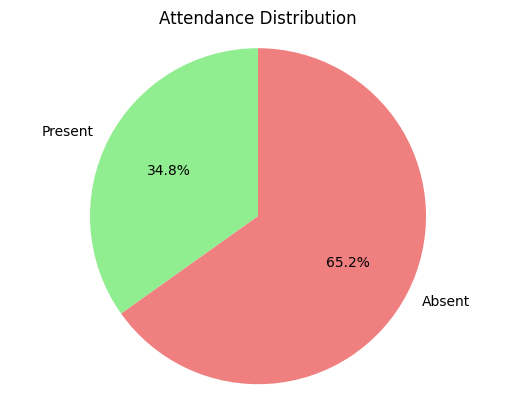

In [1]:
import matplotlib.pyplot as plt

labels = ['Present', 'Absent']
sizes = [23, 43]
colors = ['lightgreen', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Attendance Distribution")
plt.show()


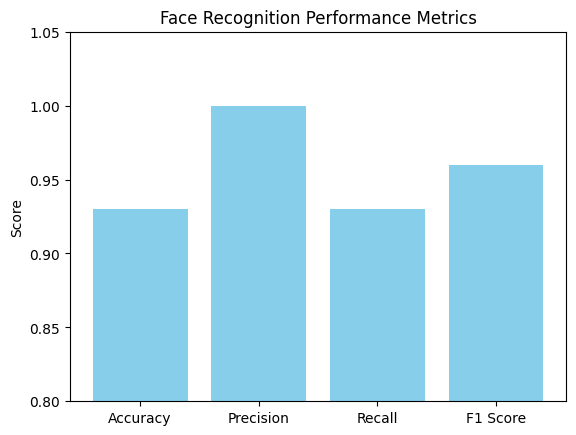

In [2]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [0.93, 1.00, 0.93, 0.96]

plt.bar(metrics, values, color='skyblue')
plt.ylim([0.8, 1.05])
plt.title("Face Recognition Performance Metrics")
plt.ylabel("Score")
plt.show()


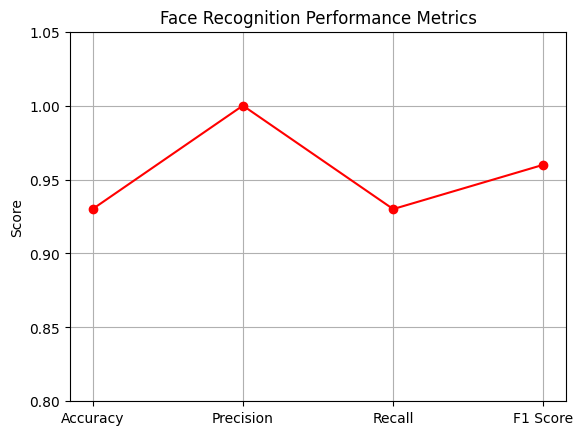

In [4]:
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [0.93, 1.00, 0.93, 0.96]

plt.plot(metrics, values, marker='o', linestyle='-', color='red')
plt.ylim([0.8, 1.05])
plt.title("Face Recognition Performance Metrics")
plt.ylabel("Score")
plt.grid(True)
plt.show()


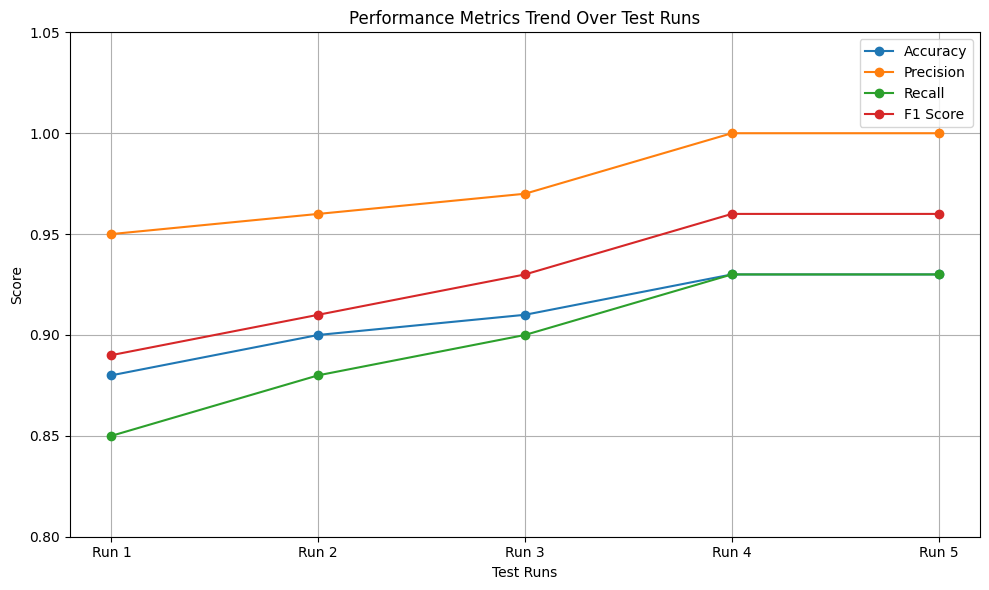

In [2]:
import matplotlib.pyplot as plt

# Sample performance trend data
runs = ['Run 1', 'Run 2', 'Run 3', 'Run 4', 'Run 5']
accuracy_values = [0.88, 0.90, 0.91, 0.93, 0.93]
precision_values = [0.95, 0.96, 0.97, 1.00, 1.00]
recall_values = [0.85, 0.88, 0.90, 0.93, 0.93]
f1_values = [0.89, 0.91, 0.93, 0.96, 0.96]

# Plotting the trend chart
plt.figure(figsize=(10, 6))
plt.plot(runs, accuracy_values, marker='o', label='Accuracy')
plt.plot(runs, precision_values, marker='o', label='Precision')
plt.plot(runs, recall_values, marker='o', label='Recall')
plt.plot(runs, f1_values, marker='o', label='F1 Score')

plt.title("Performance Metrics Trend Over Test Runs")
plt.xlabel("Test Runs")
plt.ylabel("Score")
plt.ylim(0.8, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



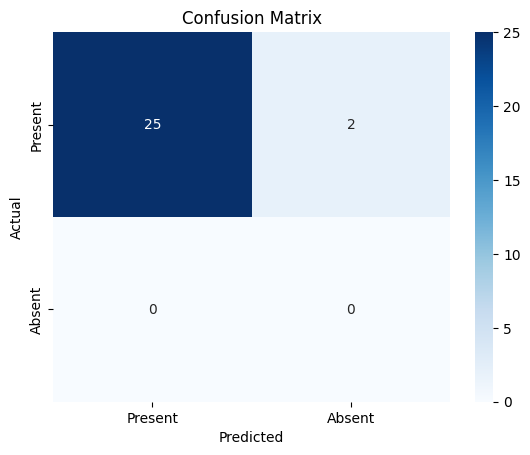

In [3]:
import seaborn as sns
import numpy as np

conf_matrix = np.array([[25, 2], [0, 0]])
labels = ['Present', 'Absent']

sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
